<a href="https://colab.research.google.com/github/adriennebohlmann/DecisionTrees_on_Gravity/blob/main/gravDT02viz42.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
import matplotlib.pyplot as plt 
from sklearn.inspection import plot_partial_dependence

In [3]:
gravd = pd.read_csv('/content/gdrive/MyDrive/gravity/gravd.csv')
gravd.columns

Index(['year', 'iso_o', 'iso_d', 'contig', 'comlang_off', 'distw', 'pop_o',
       'gdp_o', 'gdpcap_o', 'iso2_o', 'pop_d', 'gdp_d', 'gdpcap_d', 'iso2_d',
       'heg_d', 'conflict', 'indepdate', 'heg_o', 'col_to', 'col_fr',
       'col_hist', 'col_cur', 'sever', 'sib_conflict', 'gatt_o', 'gatt_d',
       'rta', 'comleg', 'comcur', 'acp_to_eu', 'gsp', 'eu_to_acp', 'gsp_rec',
       'flow', 'validmirror', 'family', 'isl_o', 'isl_d', 'lndl_o', 'lndl_d'],
      dtype='object')

In [4]:
gravd = gravd[['flow', 'distw'
                     , 'gdp_o', 'gdp_d'
                     , 'contig', 'comlang_off', 'col_hist'
                     , 'isl_o', 'isl_d', 'lndl_o', 'lndl_d'
                     ]]
gravd.isna().sum()

flow              0
distw             0
gdp_o          2006
gdp_d          1606
contig            0
comlang_off       0
col_hist          0
isl_o             0
isl_d             0
lndl_o            0
lndl_d            0
dtype: int64

drop nans and show correalation

In [5]:
gravd = gravd.dropna()
gravd.corr()

,flow,distw,gdp_o,gdp_d,contig,comlang_off,col_hist,isl_o,isl_d,lndl_o,lndl_d
flow,1.000000,-0.049890,0.167948,0.213254,0.148241,0.020537,0.044647,-0.004968,-0.006837,-0.028287,-0.027311
distw,-0.049890,1.000000,0.047489,0.048441,-0.206316,-0.072044,-0.043466,0.176368,0.166128,-0.091461,-0.095632
gdp_o,0.167948,0.047489,1.000000,-0.013492,-0.003589,0.002866,0.054973,0.005815,0.006266,-0.092983,0.014054
gdp_d,0.213254,0.048441,-0.013492,1.000000,-0.003612,0.002542,0.054800,0.006411,0.007017,0.011372,-0.091553
contig,0.148241,-0.206316,-0.003589,-0.003612,1.000000,0.110013,0.089646,-0.068270,-0.068126,0.037150,0.037822
comlang_off,0.020537,-0.072044,0.002866,0.002542,0.110013,1.000000,0.145083,0.117948,0.125097,-0.017339,-0.025740
col_hist,0.044647,-0.043466,0.054973,0.054800,0.089646,0.145083,1.000000,0.031037,0.031258,-0.024387,-0.023205
isl_o,-0.004968,0.176368,0.005815,0.006411,-0.068270,0.117948,0.031037,1.000000,0.019769,-0.234955,-0.015212
isl_d,-0.006837,0.166128,0.006266,0.007017,-0.068126,0.125097,0.031258,0.019769,1.000000,-0.017286,-0.230824
lndl_o,-0.028287,-0.091461,-0.092983,0.011372,0.037150,-0.017339,-0.024387,-0.234955,-0.017286,1.000000,-0.006014


sort data (only to check details on stratification)

In [6]:
#gravd = gravd.sort_values('flow', ignore_index=True)

how many zero obs are in the data

In [7]:
flow = np.array(gravd.flow.astype(np.float32))# *1000  # upscale
print('of', len(flow), 'observations'
      , len(flow) - np.count_nonzero(flow), ' are zero ='
      , (len(flow) - np.count_nonzero(flow))/ len(flow)*100, '%')


of 26967 observations 6970  are zero = 25.846404865205624 %


create bins for stratify in train-test-split

In [8]:
#len(gravd)

In [9]:
#bins = np.linspace(0, len(gravd), 20)
bins = np.geomspace(1, len(gravd), 100)
# with upscaled flow:
#bins = np.geomspace(start=1, stop=0.5*len(gravd), num=300)
flowZ = flow.copy()
flowZ = np.digitize(flow, bins)
#flowZ[26800:26967]

In [10]:
#flowZ[15200:15300]

In [11]:
#flowZ[6900:7000]

In [12]:
#flowZ[7600:7700]

reformat

In [13]:
# weighted geographical between origin and destination
distw = np.array(gravd.distw.astype(np.float32))

# GDP of origin
gdp_o = np.array(gravd.gdp_o.astype(np.float32))

# GDP of destination
gdp_d = np.array(gravd.gdp_d.astype(np.float32))

# Dummies 
# neighbourhood status between origin and destination
contig = np.array(gravd.contig.astype(np.int8))
# common official language of origin and destination
comlang_off = np.array(gravd.comlang_off.astype(np.int8))
# colonial ties between origin and destination
col_hist = np.array(gravd.col_hist.astype(np.int8))
# island
isl_o = np.array(gravd.isl_o.astype(np.int8))
isl_d = np.array(gravd.isl_d.astype(np.int8))
# landlocked
lndl_o = np.array(gravd.lndl_o.astype(np.int8))
lndl_d = np.array(gravd.lndl_d.astype(np.int8))

X = np.array([flowZ, distw, gdp_o, gdp_d
              , contig, comlang_off, col_hist
              , isl_o, isl_d, lndl_o, lndl_d
              ]).T


define class and some functions for convenience

In [14]:
# class for data preparation
class prepare_data:
    def __init__(self):
        self.X = X.copy()
        self.y = flow.copy()
        
    # train test split and transform
    def tts(self, rnd = 42):
         # train test split stratify on binary zero trade
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X[:,1:11], self.y
                                                                                , random_state=(rnd)
                                                                                , test_size=0.2
                                                                                , stratify=(self.X[:,0])
                                                                                )
        
# plot feature importance 
def plot_feature_importance(model):
    n_features = len(data.X_train[0,:])
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), feature_names) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

# get R2 for test and train data
def get_R2s(estimator):
    print('test R2:', estimator.score(data.X_test, data.y_test))
    print('train R2:', estimator.score(data.X_train, data.y_train))
    
# plot prediction against true values
def plt_y_pred(estimator):
    y_pred = estimator.predict(data.X_test)
    # plot feature importance
    plot_feature_importance(estimator)
    plt.show()
    # plot y against y^
    plt.scatter(y_pred, data.y_test, s = 3)
    plt.xlabel('prediced trade flow from test data')
    plt.ylabel('true trade flow from test data')
    plt.title('test vs predicted trade flow')
    plt.show()
    # plot y against y^ on log axes
    plt.loglog(y_pred, data.y_test, marker = 'o', markersize = 3, linestyle = '')
    plt.xlabel('prediced trade flow from test data')
    plt.ylabel('true trade flow from test data')
    plt.title('test vs predicted trade flow on log axes')
    plt.show()
    
def part_dep(estimator): 
    # GDP of origin and destination
    plot_partial_dependence(estimator, data.X_train, features = [1, 2, (1, 2)], feature_names=feature_names) 
     # distance with gdp
    plot_partial_dependence(estimator, data.X_train, features = [0, 1, (0, 1)], feature_names=feature_names) 
    plot_partial_dependence(estimator, data.X_train, features = [0, 2, (0, 2)], feature_names=feature_names) 
    plot_partial_dependence(estimator, data.X_train, features = [0, 3, (0, 3)], feature_names=feature_names) 
    # GDP with contig
    plot_partial_dependence(estimator, data.X_train, features = [1, 3, (1, 3)], feature_names=feature_names) 
    plot_partial_dependence(estimator, data.X_train, features = [2, 3, (2, 3)], feature_names=feature_names) 

initialize data and train-test-split

In [15]:
data = prepare_data()
data.tts()

retrieve feature names

In [16]:
feature_names = gravd.columns[1:len(X[0,:])]
feature_names

Index(['distw', 'gdp_o', 'gdp_d', 'contig', 'comlang_off', 'col_hist', 'isl_o',
       'isl_d', 'lndl_o', 'lndl_d'],
      dtype='object')

# general interpretation of the partial dependence graphs
line-plots give the marginal effect on the trade flow
for example:  till a certain threshold, the influence of distance on trade is negative (median trade decrases with increasing distance=
for 0 to 5000km this relationship is nonlinear (strongest for short distance) 
for 5000 to 10,000km distance the relationship with trade appears linear,  
above 10,000km an increase of distance does not have a positive or negative impact on trade flow

this right side graph shows the interaction of two features in their impact on trade.
e.g. the positive impact on trade of increasing GDP of origin-country seems stronger with neighboring countries

# Simple Decision Tree optimized

test R2: 0.7447457505159758
train R2: 0.9999999999999997


/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:1233: FutureWarning: the classes_ attribute is to be deprecated from version 0.22 and will be removed in 0.24.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:1233: FutureWarning: the classes_ attribute is to be deprecated from version 0.22 and will be removed in 0.24.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:1233: FutureWarning: the classes_ attribute is to be deprecated from version 0.22 and will be removed in 0.24.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:1233: FutureWarning: the classes_ attribute is to be deprecated from version 0.22 and will be removed in 0.24.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:1233: FutureWarning: the classes_ attribute is to be deprecated from version 0.22 and will b

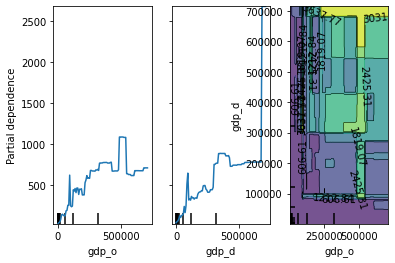

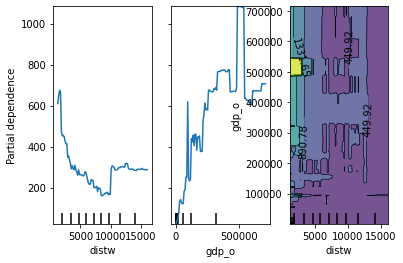

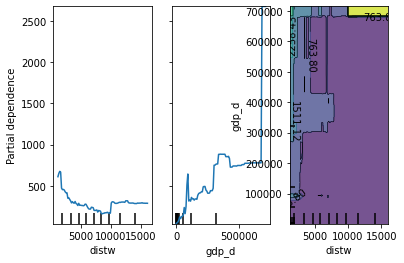

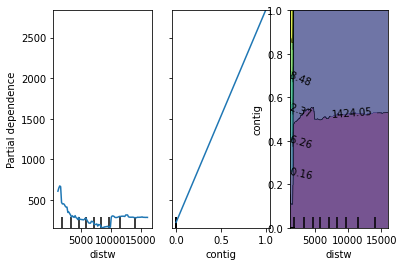

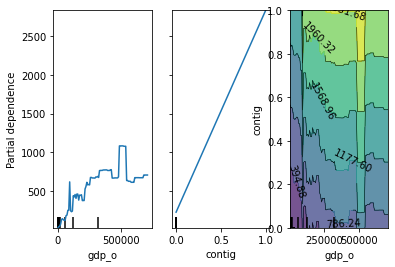

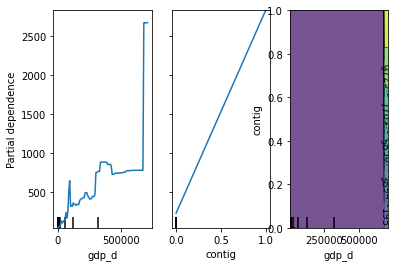

In [17]:
tree_opt = DecisionTreeRegressor(criterion='friedman_mse', max_depth=55, random_state=21) 
tree_opt_fitted = tree_opt.fit(data.X_train, data.y_train)
get_R2s(tree_opt)
part_dep(tree_opt)

# Random Forest optimized

test R2: 0.6569163224106576
train R2: 0.9423011106238012


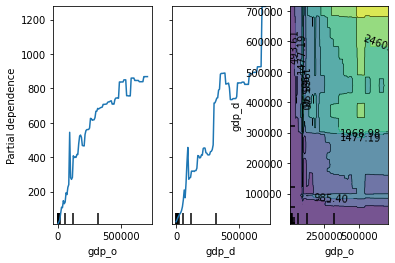

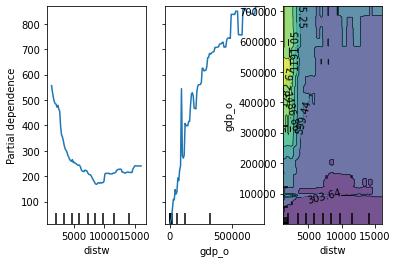

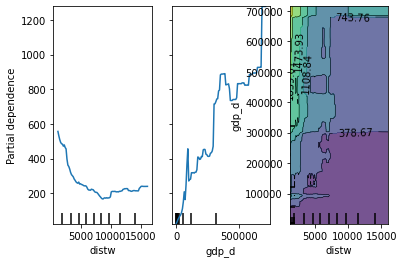

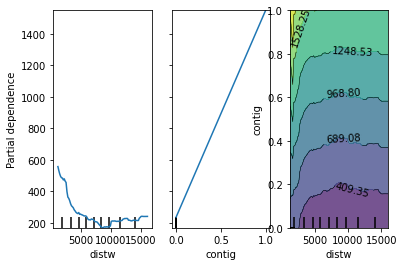

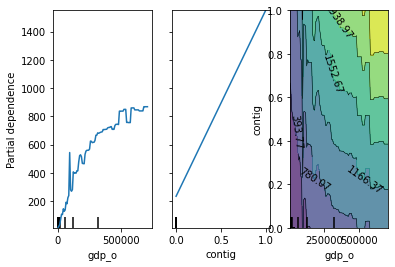

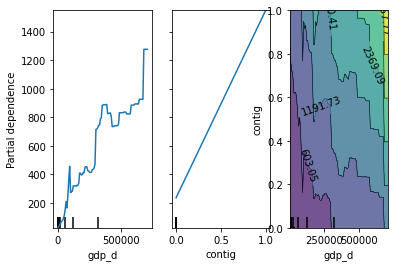

In [24]:
forest_opt = RandomForestRegressor(n_estimators=377, max_depth=13)
forest_opt.fit(data.X_train,data.y_train)
get_R2s(forest_opt)
part_dep(forest_opt)

# Gradient Booster optimized

test R2: 0.8568580410399769
train R2: 0.994195061332202


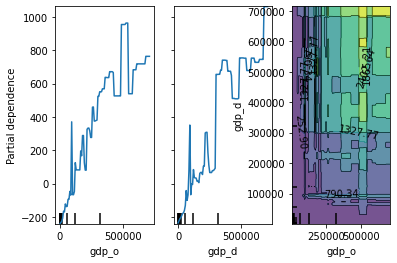

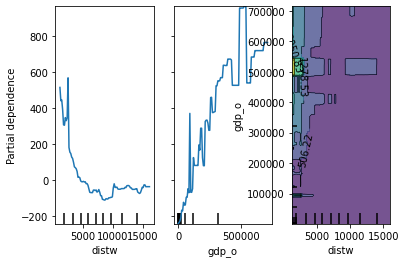

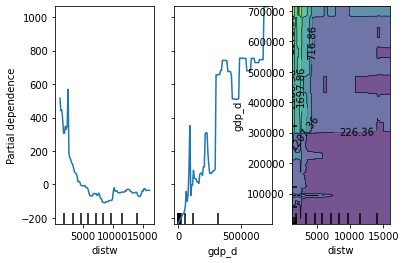

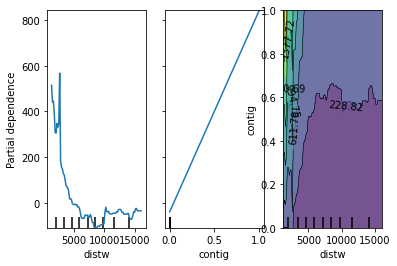

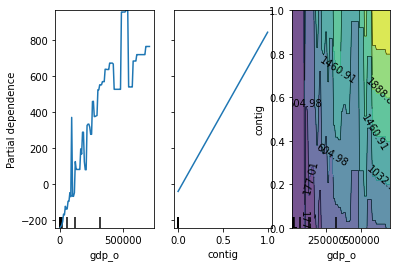

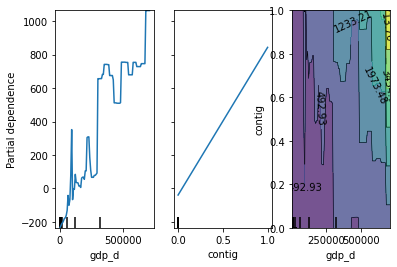

In [19]:
booster_opt = GradientBoostingRegressor(learning_rate=0.01   
                                        , loss = 'ls'          
                                        , max_depth = 5         
                                        , n_estimators = 2000
                                        )

booster_opt.fit(data.X_train,data.y_train)
get_R2s(booster_opt)
part_dep(booster_opt)

test R2: 0.7875792268437454
train R2: 0.9646251284511814


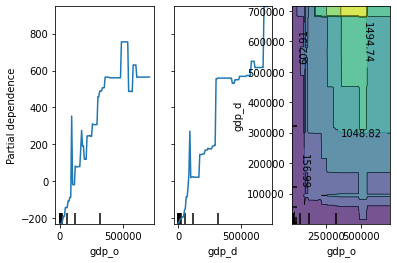

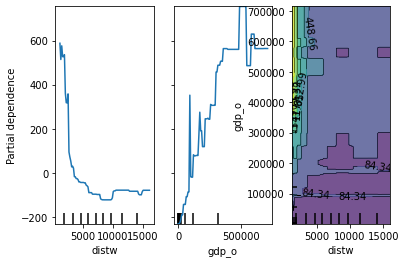

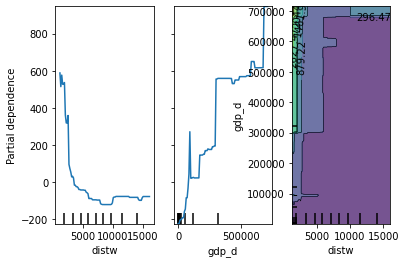

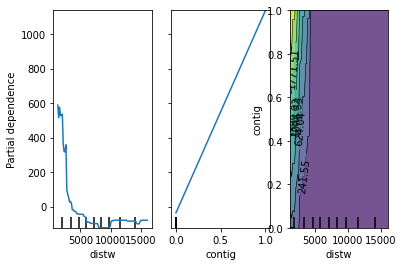

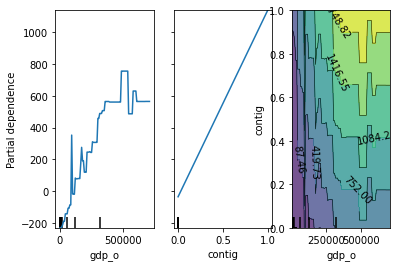

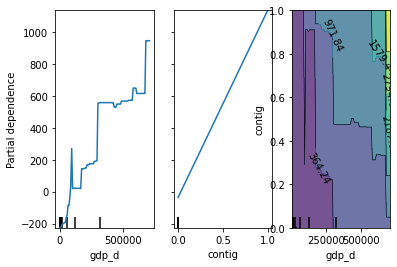

In [20]:
booster_opt = GradientBoostingRegressor(learning_rate=0.1   
                                        , loss = 'ls'          
                                        , max_depth = 3         
                                        , n_estimators = 200
                                        )

booster_opt.fit(data.X_train,data.y_train)
get_R2s(booster_opt)
part_dep(booster_opt)

# Stochastic Gradient Booster optimized

test R2: 0.7692532183637744
train R2: 0.9945068739686516


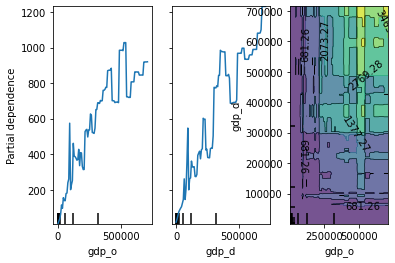

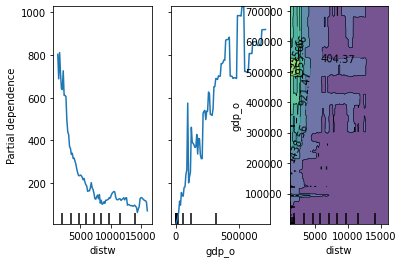

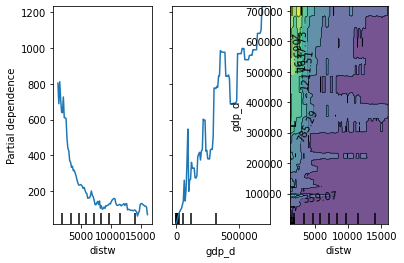

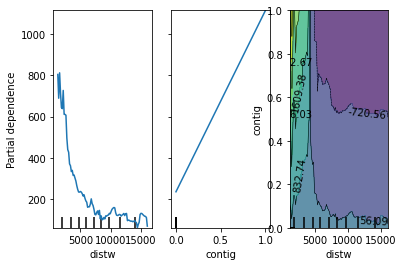

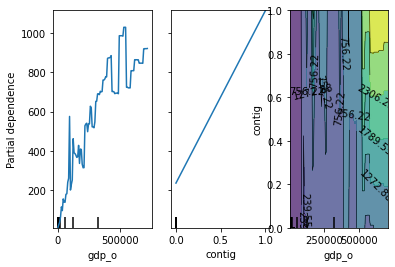

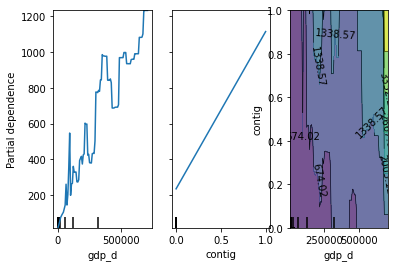

In [21]:
data.tts() 
booster_SG = GradientBoostingRegressor(random_state=7
                                       , subsample = 0.5
                                       , max_depth=7      
                                       , n_estimators = 1000
                                       , loss = 'huber'
                                        )
     
booster_SG.fit(data.X_train, data.y_train)
get_R2s(booster_SG)
part_dep(booster_SG)

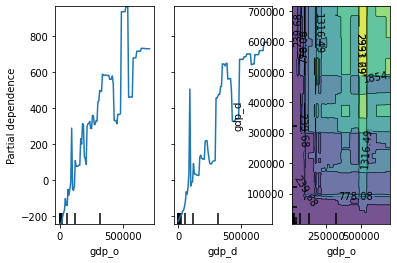

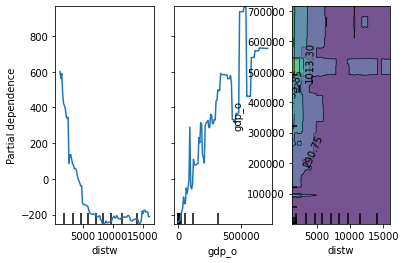

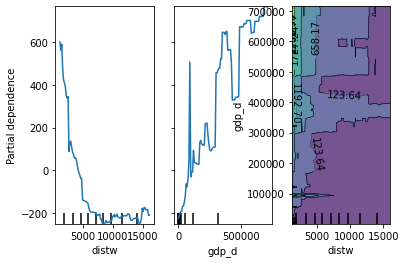

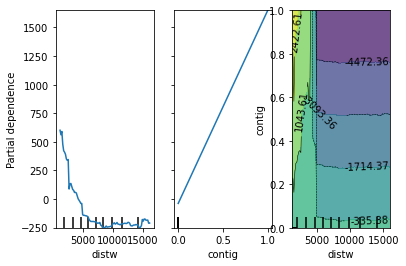

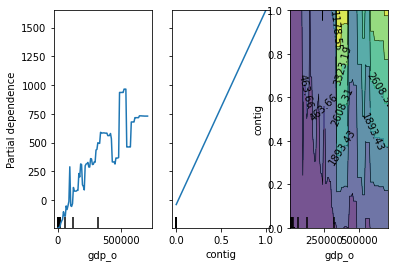

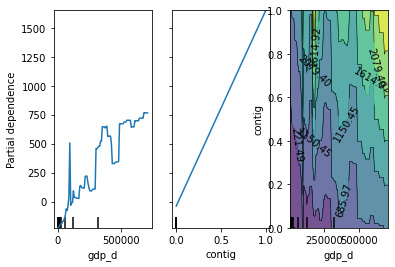

In [22]:
booster_SG_opt = GradientBoostingRegressor(subsample = 0.5
                                           , max_depth=5       
                                           , n_estimators = 200
                                            ) # 
booster_SG_opt.fit(data.X_train,data.y_train)
part_dep(booster_SG_opt)                                

# Ada Boost optimized

test R2: 0.7942585953820118
train R2: 0.931351231495401


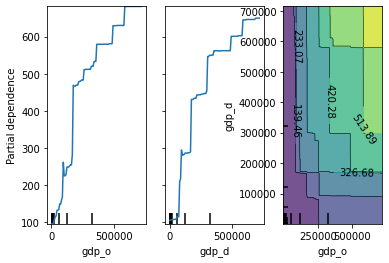

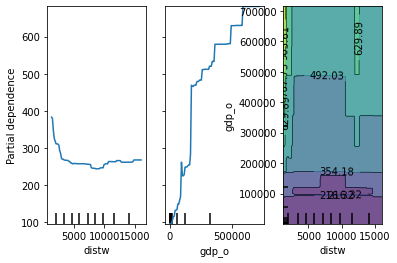

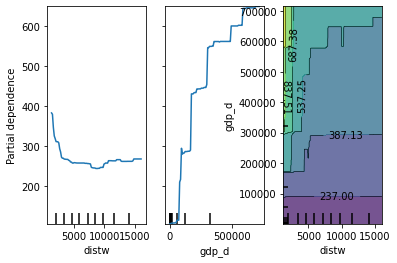

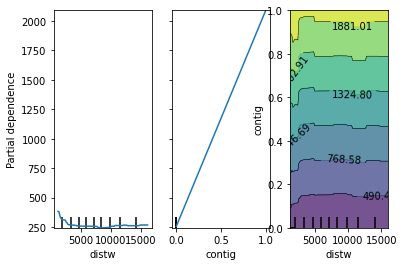

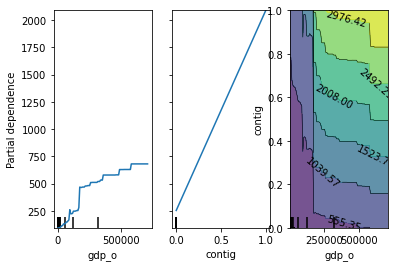

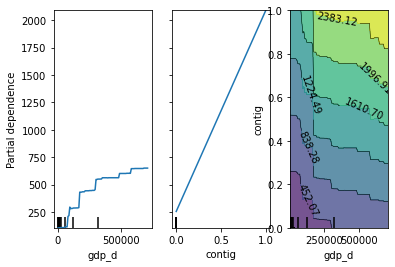

In [23]:
ada_opt = AdaBoostRegressor(DecisionTreeRegressor(max_depth=5), learning_rate=0.1, loss='square', n_estimators=200)
ada_opt.fit(data.X_train, data.y_train)
get_R2s(ada_opt)
part_dep(ada_opt)